In [1]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS 
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style

import datetime
import seaborn as sns

In [2]:
df = pd.read_csv('AB_NYC_2019.csv')

df1 =df
#df.reset_index()
df = df.drop(columns = ['id', 'host_name', 'name'])

#df = df.fillna({'reviews_per_month':0}, inplace=True)

Text(0.5,0,'Neighbourhood Group')

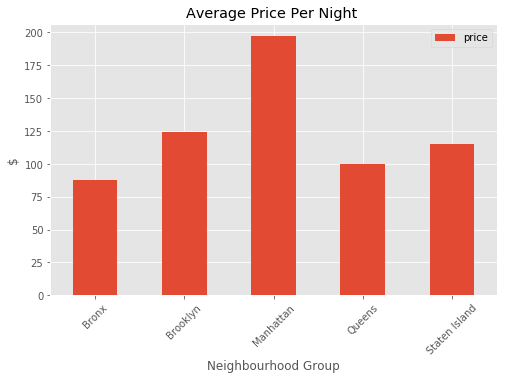

In [3]:
#check the relationship between neighborhoods and listed prices
num_properties_nh = df['neighbourhood_group'].value_counts()
avg_price_nh = (df.groupby(['neighbourhood_group'],as_index = False).mean())[['neighbourhood_group','price']]
avg_price_nh = avg_price_nh.set_index(['neighbourhood_group'])
ax = avg_price_nh.plot(kind = 'bar', figsize = (8,5))
ax.set_xticklabels(avg_price_nh.index, rotation = 45)
ax.set_title('Average Price Per Night ')
ax.set_ylabel('$')
ax.set_xlabel('Neighbourhood Group')

Text(0.5,1,'Density and distribution of prices for each neighberhood_group')

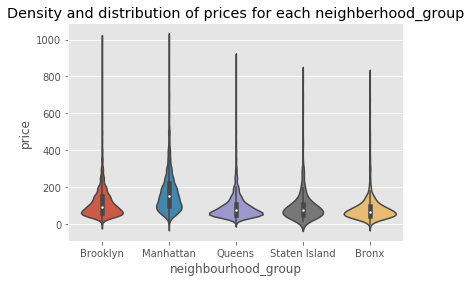

In [4]:
ax = sns.violinplot(data=df[df['price'] < 1000], x='neighbourhood_group', y='price',figsize = (20,5))
ax.set_title('Density and distribution of prices for each neighberhood_group')

In [5]:
# discard host_id feature
df = df.drop(columns = ['host_id'])

# combine neighbourhood_group and neighbourhood features into neighbourhoodcat
df['neighbourhoodcat'] = df['neighbourhood_group'] + " " + df['neighbourhood']
df = df.drop(columns = ['neighbourhood_group', 'neighbourhood'])

# construct a new feature DaysFromLastReview
d = []
for i in range(len(df)):
    if pd.isna(df['last_review'][i]):
        d.append(np.NaN)
    else:
        d.append((datetime.datetime.strptime('2019-10-31', '%Y-%m-%d') - datetime.datetime.strptime(df['last_review'][i], '%Y-%m-%d')).days)

df['DaysFromLastReview'] = d

In [6]:
# construct a new feature ListedMonths
m = []
for i in range(len(df)):
    if pd.isna(df['reviews_per_month'][i]):
        m.append(np.NaN)
    else:
        m.append(df['number_of_reviews'][i]/df['reviews_per_month'][i])
df['ListedMonths'] = m

In [7]:
df.head()

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhoodcat,DaysFromLastReview,ListedMonths
0,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,Brooklyn Kensington,377.0,42.857143
1,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,Manhattan Midtown,163.0,118.421053
2,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,Manhattan Harlem,NaN,NaN
3,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,Brooklyn Clinton Hill,118.0,58.189655
4,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,Manhattan East Harlem,346.0,90.000000


In [8]:
# fill the NaN value 
df['DaysFromLastReview'].fillna(1000,inplace = True)
df['ListedMonths'].fillna(0,inplace = True)

# convert the text value into category value
df['room_type'].replace(to_replace=['Shared room','Private room','Entire home/apt'], value=[1,2,3],inplace=True)
df = df.drop(columns = ['last_review','reviews_per_month','calculated_host_listings_count', 'availability_365'])

# delete the outliers
df = df[df['price'] > 0]
df = df[df['price'] < 1000]
corr = df.corr()

In [9]:
corr

,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,DaysFromLastReview,ListedMonths
latitude,1.000000,0.084671,-0.006829,0.063672,0.025215,-0.015315,0.032572,-0.008820
longitude,0.084671,1.000000,-0.182899,-0.264539,-0.064107,0.058173,-0.102227,-0.059342
room_type,-0.006829,-0.182899,1.000000,0.471700,0.071433,-0.001670,-0.004064,0.069437
price,0.063672,-0.264539,0.471700,1.000000,0.020715,-0.056773,0.036147,-0.036998
minimum_nights,0.025215,-0.064107,0.071433,0.020715,1.000000,-0.080127,0.092912,-0.016093
number_of_reviews,-0.015315,0.058173,-0.001670,-0.056773,-0.080127,1.000000,-0.373909,0.461201
DaysFromLastReview,0.032572,-0.102227,-0.004064,0.036147,0.092912,-0.373909,1.000000,0.006510
ListedMonths,-0.008820,-0.059342,0.069437,-0.036998,-0.016093,0.461201,0.006510,1.000000


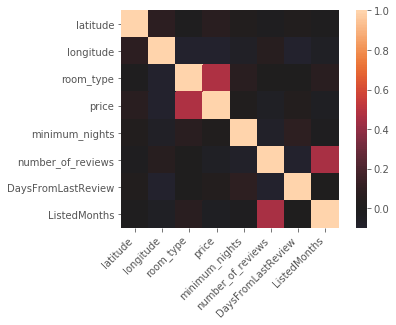

In [10]:
# plot the heatmap
ax = plt.figure()
ax = sns.heatmap(
    corr, 
    vmin=-0.1, vmax=1, center=0,
    square =True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

fig = ax.get_figure()
fig.savefig('4741 Corr Plot.png')

In [11]:
y = df.price
features = df.drop(columns = ['price'])
# apply one-hot-encoding on feature "neighbourhoodcat"
features = pd.concat([features,pd.get_dummies(df['neighbourhoodcat'])], axis=1)
features = features.drop(columns = ['neighbourhoodcat'])

Text(0.5,0,'Price ($)')

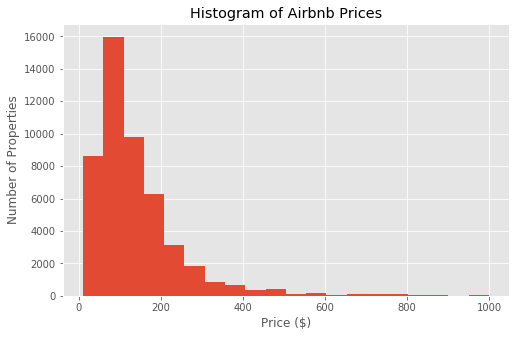

In [12]:
#check The distribution of airb2b room quantity in different price ranges
count, bin_edges = np.histogram(y,bins = 50)
ax = y.plot(kind = 'hist', figsize = (8,5),bins = 20)

ax.set_title('Histogram of Airbnb Prices')
ax.set_ylabel('Number of Properties')
ax.set_xlabel('Price ($)')

In [13]:
features.head()

,latitude,longitude,room_type,minimum_nights,number_of_reviews,DaysFromLastReview,ListedMonths,Bronx Allerton,Bronx Baychester,Bronx Belmont,...,Staten Island South Beach,Staten Island St. George,Staten Island Stapleton,Staten Island Todt Hill,Staten Island Tompkinsville,Staten Island Tottenville,Staten Island West Brighton,Staten Island Westerleigh,Staten Island Willowbrook,Staten Island Woodrow
0,40.64749,-73.97237,2,1,9,377.0,42.857143,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,40.75362,-73.98377,3,1,45,163.0,118.421053,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,40.80902,-73.94190,2,3,0,1000.0,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,40.68514,-73.95976,3,1,270,118.0,58.189655,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,40.79851,-73.94399,3,10,9,346.0,90.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Text(0.5,0,'Room Type')

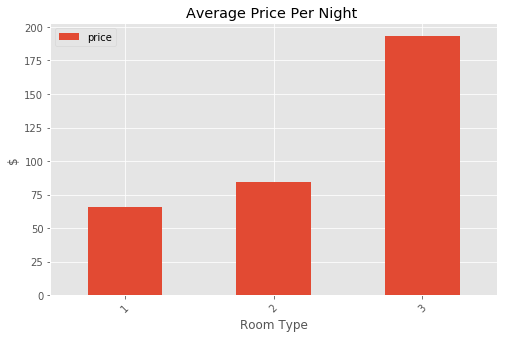

In [14]:
#check the relationship between room types and listed prices
num_properties_rt = df['room_type'].value_counts()
avg_price_rt = (df.groupby(['room_type'],as_index = False).mean())[['room_type','price']]
avg_price_rt = avg_price_rt.set_index(['room_type'])
ax = avg_price_rt.plot(kind = 'bar', figsize = (8,5))
ax.set_xticklabels(avg_price_rt.index, rotation = 45)
ax.set_title('Average Price Per Night ')
ax.set_ylabel('$')
ax.set_xlabel('Room Type')

In [16]:
#Wordcloud, availability map
stopwords = set(STOPWORDS)
name_words = ' '
for string in df1.name: 
      
    # typecaste each val to string 
    val = str(string) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        name_words = name_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(name_words)

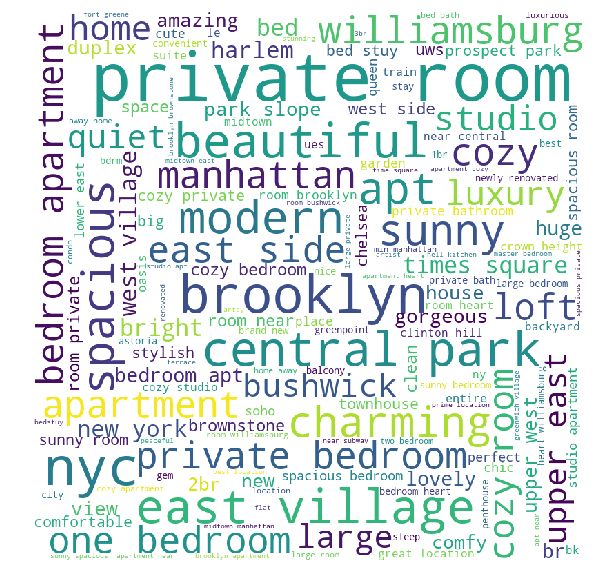

In [17]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()